In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimi
import sklearn.preprocessing
import sklearn.metrics
import torchvision
from utils.Training_utils import *

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.CustomDataset import CustomDataset
from utils.SimpleDNN import SimpleDNN
from utils.SimpleCNN import SimpleCNN
from SelectNet import *
from tqdm import tqdm
from tensorboardX import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D




^((?!.*((w_prine)|(w_value)).*).)*$


# Synthesized dataset

(5000, 8) (5000, 1)
0.466 0.49884266


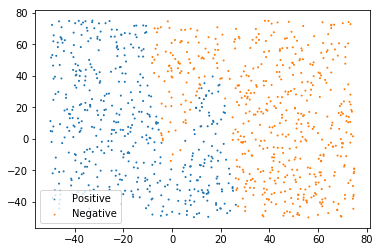

 17%|█▋        | 3120/18000 [01:54<09:07, 27.20it/s, acc :      0.898, val_acc :      0.930, loss:      0.208,                              val_loss:     0.1670, w_loss :      0.000, entropy :      0.000,                              regularizer :      0.076                                          x1:125.00,                                         x2:125.00,                                    -0.5*x2:125.00,                             uniform random:125.00,                              normal random:125.00,                            x1 permuatation:125.00,                           x1^2 permutation:125.00,                             x2 permutation:125.00]

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimi
import sklearn.preprocessing
import sklearn.metrics
import torchvision
from utils.Training_utils import *

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.CustomDataset import CustomDataset
from utils.SimpleDNN import SimpleDNN
from utils.SimpleCNN import SimpleCNN
from SelectNet import *
from tqdm import tqdm
from tensorboardX import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



def F1(x1, x2):
    return 0.02*np.power(x1, 3) - 0.5*np.power(x1, 2) + 0.8*x2 +12.
def F2(x1, x2):
    return -0.5*x2 
def add_noise(X, percentage):
    ret = X.copy()
    N, dim = X.shape
    for i in range(dim):
        rand_idx = np.random.permutation(N)[:(N//100)*percentage]
        ret[rand_idx, i] = 0
        m = np.mean(ret[:, i])
        ret[rand_idx, i] = m
    return ret
#     
    

N = 5000
low = -50
high = 75
cut = 0
x1 = np.random.uniform(low, high, N)
x2 = np.random.uniform(low, high, N)
x3 = F2(x1, x2)
x4 = np.random.uniform(low, high, N)
x5 = np.random.normal((low+high)/2., 10, N)

x6 = x1[np.random.permutation(N)]
x7 = np.power(x1, 2)[np.random.permutation(N)]
x8 = x2[np.random.permutation(N)]
X = np.swapaxes(np.vstack([x1, x2, x3, x4, x5, x6, x7, x8]), 0, 1)
feature_names = [
            'x1', 'x2', '-0.5*x2', 'uniform random', 'normal random', 
            'x1 permuatation', 'x1^2 permutation', 'x2 permutation',
]

Y = F1(x1, x2).reshape([-1, 1]) < cut
Y = Y.astype(np.float32)
print X.shape, Y.shape
print np.mean(Y), np.std(Y)

# visualization
vis_N = np.random.permutation(N)[:1000]
# pos_mask = (Y < cut)[:vis_N]
# neg_mask = (Y >= cut)[:vis_N]
pos_mask = Y[vis_N] == 1
neg_mask = Y[vis_N] == 0
# print mask
plt.scatter(x1[vis_N], x2[vis_N], marker='o', s=pos_mask, label='Positive')
plt.scatter(x1[vis_N], x2[vis_N], marker='o', s=neg_mask, label='Negative')
plt.legend()
plt.show()
# 
batch_size = 256
N = len(Y)
x_transforms = transforms.Compose([
    transforms.Lambda(lambda x:torch.from_numpy(x)),
    transforms.Lambda(lambda x:x.float()),
    transforms.Lambda(lambda x:x.cuda()),
])
y_transforms = transforms.Compose([
    transforms.Lambda(lambda y:torch.from_numpy(y)),
    transforms.Lambda(lambda y:y.type(torch.float).flatten()),
    transforms.Lambda(lambda y:y.cuda()),
])
X = add_noise(X, 5)
X = sklearn.preprocessing.normalize(X, axis=0)

train_dataset, val_dataset = torch.utils.data.random_split(CustomDataset(X, Y,
                                                                         x_transforms=x_transforms,
                                                                         y_transforms=y_transforms,
                                                                        ), [N-N//10, N//10])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_G = generator(train_dataloader)
val_G = generator(val_dataloader)

class Net(nn.Module):
    def __init__(self, in_dim):
        super(Net, self).__init__()
        self.dnn = SimpleDNN(in_dim, 16, 1, 3, F.relu)
        self.kernel_weights = self.dnn.kernel_weights
        
    def forward(self, x):
        x = self.dnn(x)
        return x
def synthesized_noise_fn(x):
    noise_distribution = torch.distributions.Uniform(-100, 100)
    x[:, 2:] += noise_distribution.sample(x.shape)[:, 2:].cuda()
    return x

# for ver in [0, 1, 2, 3, 4, 5]:
# for ver in [2]:
# for ver in [5]:
for ver in [0]:
    for use_norm in [True, False]:
        p = 1
        simple_model = Net(X.shape[-1])
        model = SelectNet(X.shape[-1], simple_model, simple_model.kernel_weights, ver, p, use_norm_lay=use_norm).cuda()
        opt = torch.optim.Adam(model.parameters(), )
        alpha = 0.1
        beta = 100
    #     alpha = 0
    #     beta = 0
        gamma = 0
        epochs = 1000 if ver not in [3] else 1000
        iters = 1
        log_name = 'Synthesized_norm' if use_norm else 'Synthesized'
        src_loss_criterion = nn.BCEWithLogitsLoss()
        train(model, opt, src_loss_criterion, train_dataloader, 
              val_dataloader, alpha, beta, gamma, 
              epochs, noise_fn=synthesized_noise_fn, 
              metric_fn=calc_accracy_sigmoid, log_name=log_name, 
              feature_names=feature_names, 
              log_period=10, K=4
             )


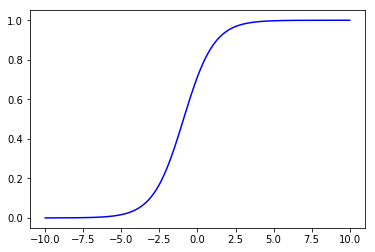

In [12]:
def sigmoid(x):
    return 1. / (1. + 0.4*np.exp(-x))
def F(x):
    return sigmoid(x)
x = np.linspace(-10, 10, 1000)
y = F(x)
plt.plot(x, y, 'b-')
plt.show()

In [5]:
X.shape
np.mean(X, axis=0).shape

(8,)

In [2]:
w = model.w
print w
print torch.sum(F.relu(w))
print model.select_lay.calc_ratio()
w / torch.sum(w)
# print torch.softmax(w, dim=-1)
# model.select_lay.calc_ratio()

Parameter containing:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       requires_grad=True)
tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<DivBackward0>)


tensor([[nan, nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [2]:
ver

5

# Dengue data set

In [ ]:
data = np.load('/home/k123/git/ncku_project/src/medical/data.npz')
X = data['x']
Y = data['y']

iid1 = [0, 1, 9, 10, 11, 24]
iid2 = [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 24]
iid3 = [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 24, 25, 26, 27, 28, 29, 30, 31]
iid4 = np.arange(X.shape[-1])
iid = iid4


X = data['x'][:, iid]
X = data['x']
v_mask = data['missing_mask']
Y = data['y']
X = X[v_mask, :].astype(np.float32)
Y = Y[v_mask, :].astype(np.float32)

print X.shape, Y.shape
print sum(Y)
            

batch_size = 256
N = len(Y)
x_transforms = transforms.Compose([
    transforms.Lambda(lambda x:torch.from_numpy(x)),
    transforms.Lambda(lambda x:x.float()),
    transforms.Lambda(lambda x:x.cuda()),
])
y_transforms = transforms.Compose([
    transforms.Lambda(lambda y:torch.from_numpy(y)),
    transforms.Lambda(lambda y:y.type(torch.float).flatten()),
    transforms.Lambda(lambda y:y.cuda()),
])
            

train_dataset, val_dataset = torch.utils.data.random_split(CustomDataset(X, Y,
                                                                         x_transforms=x_transforms,
                                                                         y_transforms=y_transforms,
                                                                        ), [N-N//10, N//10])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_G = generator(train_dataloader)
val_G = generator(val_dataloader)

class Net(nn.Module):
    def __init__(self, in_dim):
        super(Net, self).__init__()
        self.dnn = SimpleDNN(in_dim, 16, 1, 3, F.relu)
        self.kernel_weights = self.dnn.kernel_weights
        
    def forward(self, x):
        x = self.dnn(x)
        return x
def dengue_noise_fn(x):
    noise_distribution = torch.distributions.Uniform(0, 50)
    rest_idx = [i for i in range(x.shape[-1]) if i not in [0, 1, 9, 10, 11, 24]]
    x[:, 0] += noise_distribution.sample(x.shape)[:, 0].cuda()
    return x
# for ver in [0, 1, 2, 3, 4]:
# for ver in [2]:
for ver in [0, 1, 2, 3, 4, 5]:
#     for use_norm in [True, False]:
    for use_norm in [True, False]:
        p = 1
        simple_model = Net(X.shape[-1])
        model = SelectNet(X.shape[-1], simple_model, simple_model.kernel_weights, ver, p, use_norm_lay=use_norm).cuda()
        opt = torch.optim.Adam(model.parameters(), )
        alpha = 0.1
        beta = 100
    #     alpha = 0
    #     beta = 0
        gamma = 0
        epochs = 2000 if ver not in [3] else 2000
        iters = 1
        log_name = 'Dengue_norm' if use_norm else 'Dengue'
        src_loss_criterion = nn.BCEWithLogitsLoss()
        train(model, opt, src_loss_criterion, train_dataloader, 
              val_dataloader, alpha, beta, gamma, 
              epochs, noise_fn=dengue_noise_fn, 
              metric_fn=calc_accracy_sigmoid, log_name=log_name, 
              feature_names=data['feature_names'], 
              log_period=100, K=4, warn_up_acc=0.8
             )


(4894, 63) (4894, 1)
[2942.]


  0%|          | 1/36000 [00:00<1:04:49,  9.25it/s, acc :      0.363, val_acc :      0.410, loss:      2.291,                              val_loss:     1.7968, w_loss :      0.018, entropy :      5.974,                              regularizer :      0.016                                        Temp: 15.86,                                        age: 15.86,                                        SBP: 15.86,                                        DBP: 15.86,                                     bmi>30: 15.86,                             merged_smoking: 15.86,                            merged_drinking: 15.86,                             merged_betenut: 15.86]

done


  0%|          | 1/36000 [00:00<1:12:27,  8.28it/s, acc :      0.562, val_acc :      0.598, loss:      0.691,                              val_loss:     0.6880, w_loss :      0.016, entropy :      5.974,                              regularizer :      0.016                                        Temp: 15.86,                                        age: 15.86,                                        SBP: 15.86,                                        DBP: 15.86,                                     bmi>30: 15.86,                             merged_smoking: 15.86,                            merged_drinking: 15.86,                             merged_betenut: 15.86]

done


  0%|          | 1/36000 [00:00<1:19:50,  7.51it/s, acc :      0.613, val_acc :      0.613, loss:      1.417,                              val_loss:     0.9862, w_loss :      0.016, entropy :      5.974,                              regularizer :      0.015                                        Temp: 15.86,                                        age: 15.86,                                        SBP: 15.86,                                        DBP: 15.86,                                     bmi>30: 15.86,                             merged_smoking: 15.86,                            merged_drinking: 15.86,                             merged_betenut: 15.86]

done


  3%|▎         | 985/36000 [02:21<1:27:25,  6.68it/s, acc :      0.777, val_acc :      0.807, loss:      0.456,                              val_loss:     0.4660, w_loss :      0.016, entropy :      5.388,                              regularizer :      0.019                                Hypertension:  0.47,                      Pregnancy/ Postpartum:  0.78,                  Haematological Malignancy:  1.20,                          Dementia/Epilepsy:  1.24,                                triage_rank: 37.10,                       Severe Liver Disease: 39.29,                                    exam_Hb: 52.15,                                   exam_WBC: 60.87]

In [ ]:
w_ratio = model.select_lay.calc_ratio().cpu().detach().numpy().flatten()
sorted_ratio = sorted([(data['feature_names'][i],x) for i,x in enumerate(w_ratio)], key=lambda x:x[1], reverse=True)
for x in sorted_ratio[:22]:
    print x
names = [x[0] for x in sorted_ratio[:22]]
print names
idx =[data['feature_names'].tolist().index(n) for n in names]
print sorted(idx)



# CIFAR10 DATASET

In [ ]:


batch_size = 128
final_size = 20
final_in_dim = final_size*final_size*3
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn = SimpleCNN(3, 16, 3)
        self.kernel_weights = self.cnn.kernel_weights
        self.linear = nn.Linear(4*64, 10)
        
    def forward(self, x):
        batch = x.shape[0]
        x = x.view(batch, 3, final_size, final_size)
        x = self.cnn(x)
        out = self.linear(x.view(batch, -1))
        return out
def cifar_noise_fn(x):
    return x

# Data
print('==> Preparing data..')
x_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([final_size, final_size]),
#     transforms.Grayscale(),
    transforms.RandomCrop(20, padding=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Lambda(lambda x:x.float().flatten()),
    transforms.Lambda(lambda x:x.cuda()),
])
y_transforms = transforms.Compose([
    transforms.Lambda(lambda y:torch.from_numpy(y).type(torch.long).flatten()),
    transforms.Lambda(lambda y:y.cuda()),
])


trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=None)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=None)


train_dataset = CustomDataset(trainset.train_data, np.array(trainset.train_labels).reshape([-1, 1]),
                             x_transforms=x_transforms,
                             y_transforms=y_transforms,
                             )
val_dataset = CustomDataset(testset.test_data, np.array(testset.test_labels).reshape([-1, 1]),
                            x_transforms=x_transforms,
                            y_transforms=y_transforms,
                           )
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



G = generator(train_dataset)
# DNN_model = SimpleDNN(X.shape[-1], 128, 10, 3, F.relu)
# model = SelectNet(X.shape[-1], DNN_model, DNN_model.kernel_weights).cuda()
simple_model = Net()
model = SelectNet(final_in_dim, simple_model, simple_model.kernel_weights).cuda()
opt = torch.optim.Adam(model.parameters())
alpha = 0.1
beta = 100
# beta = 0
gamma = 0
epochs = 10000
iters = 1
src_loss_criterion = nn.CrossEntropyLoss()
feature_names = ['pixel_%d' % (i+1) for i in range(final_in_dim)]
train(model, opt, src_loss_criterion, train_dataloader, 
      val_dataloader, alpha, beta, gamma, 
      epochs, noise_fn=cifar_noise_fn, 
      metric_fn=calc_accracy_softmax, log_name='Cifar-10', 
      feature_names=feature_names,
      log_period=50, K=4
     )


In [ ]:
np.array(trainset.train_labels).shape

# MNIST DATASET

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimi
import sklearn.preprocessing
import sklearn.metrics
import torchvision
from utils.Training_utils import *

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.CustomDataset import CustomDataset
from utils.SimpleDNN import SimpleDNN
from utils.SimpleCNN import SimpleCNN
from SelectNet import *
from tqdm import tqdm
from tensorboardX import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D




from torchvision import datasets, transforms
from utils.SimpleCNN import SimpleCNN
import sklearn.metrics


def calc_accracy(y, out):
    label = y.flatten().cpu().detach().numpy().astype(np.int)
    pred = torch.argmax(out, dim=-1).cpu().detach().numpy().astype(np.int)
    return sklearn.metrics.accuracy_score(label, pred)

def add_noise_on_pixel(x, pixel_mask, distribution):
    noise = distribution.sample(x.size()).cuda()
    batch = x.shape[0]
    ret = x.clone()
    ret += pixel_mask.repeat(batch, 1).type(torch.FloatTensor).cuda()*noise
    return ret

noise_distribution = torch.distributions.Uniform(-1, 1)
noise_pixel_mask = torch.tensor([[1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 1, 1]], dtype=torch.uint8)
def mnist_noise_fn(x):
    ret = add_noise_on_pixel(x, noise_pixel_mask, noise_distribution)
    return ret
            
class Net(nn.Module):
    def __init__(self, in_dim):
        super(Net, self).__init__()
        self.cnn = SimpleCNN(1, 16, 2)
        self.in_dim = in_dim
        self.kernel_weights = self.cnn.kernel_weights
        self.linear = nn.Linear(4*32, 10)
        
    def forward(self, x):
        batch = x.shape[0]
        x = x.view(batch, 1, self.in_dim, self.in_dim)
        x = self.cnn(x)
        out = self.linear(x.view(batch, -1))
        return out

batch_size = 256
# Data
print('==> Preparing data..')
final_size = 10
final_in_dim = 10*10
x_transforms = transforms.Compose([
    transforms.Lambda(lambda x: torch.unsqueeze(x, 0)),
    transforms.ToPILImage(),
    transforms.Resize([final_size, final_size]),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x:x.float().flatten()),
    transforms.Lambda(lambda x:x.cuda()),
])
y_transforms = transforms.Compose([
    transforms.Lambda(lambda y:torch.from_numpy(y).type(torch.long).flatten()),
    transforms.Lambda(lambda y:y.cuda()),
])


trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=None)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=None)


train_dataset = CustomDataset(trainset.train_data, np.array(trainset.train_labels).reshape([-1, 1]),
                             x_transforms=x_transforms,
                             y_transforms=y_transforms,
                             )
val_dataset = CustomDataset(testset.test_data, np.array(testset.test_labels).reshape([-1, 1]),
                            x_transforms=x_transforms,
                            y_transforms=y_transforms,
                           )
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
G = generator(train_dataloader)
x, y = next(G)

feature_names = ['pixel_%d' % i for i in range(final_in_dim)]
for ver in [0, 1, 2, 3, 4, 5]:
    p = 1
    simple_model = Net(final_size)
    model = SelectNet(final_in_dim, simple_model, simple_model.kernel_weights, ver, p, use_norm_lay=False).cuda()
        
    opt = torch.optim.Adam(model.parameters(), )
    alpha = 0.1
    beta = 100
#     alpha = 0
#     beta = 0
    gamma = 0
    epochs = 50 if ver not in [3] else 100
    iters = 1
    log_name = 'mnist'
    src_loss_criterion = nn.CrossEntropyLoss()
    train(model, opt, src_loss_criterion, train_dataloader, 
          val_dataloader, alpha, beta, gamma, 
          epochs, noise_fn=mnist_noise_fn, 
          metric_fn=calc_accracy_softmax, log_name=log_name, 
          feature_names=feature_names, 
          log_period=10, K=4, warn_up_acc=0.8
         )



^((?!.*((w_prine)|(w_value)).*).)*$
==> Preparing data..


  0%|          | 1/11750 [00:00<29:32,  6.63it/s, acc :      0.145, val_acc :      0.113, loss:      2.351,                              val_loss:     2.2944, w_loss :      0.010, entropy :      6.639,                              regularizer :      0.008                                     pixel_0:  9.99,                                    pixel_1:  9.99,                                    pixel_2:  9.99,                                    pixel_3:  9.99,                                   pixel_96:  9.99,                                   pixel_97:  9.99,                                   pixel_98:  9.99,                                   pixel_99:  9.99]

done


  0%|          | 1/11750 [00:00<30:28,  6.42it/s, acc :      0.168, val_acc :      0.047, loss:      2.344,                              val_loss:     2.3138, w_loss :      0.953, entropy :      0.000,                              regularizer :      0.008                                     pixel_0: 10.00,                                    pixel_1: 10.00,                                    pixel_2: 10.00,                                    pixel_3: 10.00,                                   pixel_96: 10.00,                                   pixel_97: 10.00,                                   pixel_98: 10.00,                                   pixel_99: 10.00]

done


100%|██████████| 11750/11750 [36:07<00:00,  5.94it/s, acc :      0.073, val_acc :      0.066, loss:        nan,                              val_loss:        nan, w_loss :        nan, entropy :      0.000,                              regularizer :        nan                                     pixel_0:   nan,                                    pixel_1:   nan,                                    pixel_2:   nan,                                    pixel_3:   nan,                                   pixel_96:   nan,                                   pixel_97:   nan,                                   pixel_98:   nan,                                   pixel_99:   nan]


done


In [4]:
G = generator(train_dataloader)
x, y = next(G)
print x.shape
print torch.mean(x), torch.std(x)

torch.Size([256, 100])
tensor(-0.4241, device='cuda:0') tensor(0.0034, device='cuda:0')


In [4]:
trainset.train_data.shape

torch.Size([60000, 28, 28])

In [ ]:
# torch.save(model, './models/mnist_10x10.hdf5')
# print val_x.shape
# print sorted_ratio
# print ['%.5f' % w for w in sorted_ratio]
s = 0
for i, (_, w) in enumerate(reversed(sorted_ratio)):
    s += w
#     print '%3d, %.7f, %.7f' % (i, s, w)
# print ['%d, %.7f' % w[1] for w in sorted_ratio]
# print w_ratio
# plt.plot(np.ones([100,]), w_ratio, 'r.')
ratio = model.select_lay.calc_ratio().cpu().detach().numpy().flatten()
plt.hist(ratio, bins=np.linspace(0, 0.1, 100))
plt.show()

In [ ]:
a = torch.tensor([[1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 1, 1]], dtype=torch.uint8)
print a

In [ ]:
threshold = 0.001
def get_torch_mask(model, threshold):
    ratio = model.select_lay.calc_ratio()
    pixel_mask =  ratio*model.select_lay.in_dim < threshold
    return pixel_mask.cpu().detach()
    
def add_noise_on_pixel(x, pixel_mask):
    uniform = torch.distributions.Uniform(0.5, 1)
    noise = uniform.sample(x.size())
    batch = x.shape[0]
    ret = x.clone()
    ret += pixel_mask.repeat(batch, 1).type(torch.FloatTensor)*noise
    return ret

def test_accuracy_with_noise(model, val_G, mask, iters=100):
    mean_acc = []
    model.eval()
    with torch.no_grad():
        for it in xrange(iters):
            x, y = next(val_G)
            x, y = x, y.type(torch.long).flatten().cuda()
            x = add_noise_on_pixel(x, pixel_mask).cuda()
            out = model(x)
            acc = calc_accracy(y, out)
            mean_acc.append(acc)
    return np.mean(mean_acc)
            
    
pixel_mask = get_torch_mask(model, threshold)
print pixel_mask
print pixel_mask.shape
pixel_idx = [i for i in range(pixel_mask.shape[-1]) if pixel_mask[0, i] == 1]
# print np.[pixel_idx]
print test_accuracy_with_noise(model, val_G, pixel_mask, 100)


In [ ]:
def visualize_noise(img, pixel_mask):
    assert len(img.shape) == 3 and img.shape[-1] == 3
    mask = pixel_mask.reshape(10, 10)
    mask = np.swapaxes(mask, 0, 1)
    
    ret = img.copy()
    np.putmask(ret[:,:,0], mask, 1)
    np.putmask(ret[:,:,1], mask, 0)
    np.putmask(ret[:,:,2], mask, 0)
    return ret

def denormalize(x):
    return x*0.3081 + 0.1307
    
for x, y in val_dataloader:
    print x.shape, y.shape
    break
x = x[0:1,:]
x = denormalize(x)
m = x.numpy()
m = np.repeat(m, 3, axis=0)
# m = add_noise_on_pixel(m, pixel_idx)
m = m.reshape([3, 10, 10])
m = np.swapaxes(m, 0, 2)
m = np.swapaxes(m, 0, 1)
m = visualize_noise(m, pixel_mask)

print m.shape, np.min(m), np.max(m)
print y[0]
plt.imshow(m, cmap=None, vmin=0, vmax=1)

In [ ]:
    
def visualize_noise(img, pixel_mask):
    assert len(img.shape) == 3 and img.shape[-1] == 3
    mask = pixel_mask.reshape(10, 10)
    mask = np.swapaxes(mask, 0, 1)
    
    ret = img.copy()
    np.putmask(ret[:,:,0], mask, 1)
    np.putmask(ret[:,:,1], mask, 0)
    np.putmask(ret[:,:,2], mask, 0)
    return ret

def denormalize(x):
    return x*0.3081 + 0.1307
    
for x, y in val_dataloader:
    print x.shape, y.shape
    break
x = x[0:1,:]
x = denormalize(x)
m = x.numpy()
m = np.repeat(m, 3, axis=0)
# m = add_noise_on_pixel(m, pixel_idx)
m = m.reshape([3, 10, 10])
m = np.swapaxes(m, 0, 2)
m = np.swapaxes(m, 0, 1)
m = visualize_noise(m, pixel_mask)

print m.shape, np.min(m), np.max(m)
print y[0]
plt.imshow(m, cmap=None, vmin=0, vmax=1)

In [ ]:
# mnist model visualization

# in Iris dataset

In [ ]:
from sklearn.datasets import load_iris
from sklearn import tree
import sklearn.metrics

def calc_accracy(y, out):
    label = y.flatten().cpu().detach().numpy().astype(np.int)
    pred = torch.argmax(out, dim=-1).cpu().detach().numpy().astype(np.int)
    return sklearn.metrics.accuracy_score(label, pred)
            

iris = load_iris()
X = iris.data.astype(np.float32)
Y = iris.target.reshape([-1, 1]).astype(np.float32)
# print iris.data.shape
N = len(Y)
batch_size = 8
train_dataset, val_dataset = torch.utils.data.random_split(CustomDataset(X, Y), [N-N//10, N//10])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_G = generator(train_dataloader)
val_G = generator(val_dataloader)


DNN_model = SimpleDNN(X.shape[-1], 16, 3, 2, F.relu)
model = SelectNet(X.shape[-1], DNN_model, DNN_model.kernel_weights).cuda()
opt = torch.optim.Adam(model.parameters())
alpha = 0.1
beta = 100
gamma = 0
epochs = 10000
iters = 1
noise_std = 25
noise_col_idx = []
writer = SummaryWriter('./AE_logs/Iris-a%f,b%f,g%f' % (alpha, beta, gamma))
src_loss_criterion = nn.CrossEntropyLoss()
with tqdm(total=epochs*len(train_dataloader)) as pbar:
    for epoch in range(epochs):
#         mask_idx = np.random.randint(0, X.shape[-1])
        for _ in range(len(train_dataloader)):
            x, y = next(train_G)
            noised_x = add_masked_noise(x, noise_std, noise_col_idx)
            x, y = x.cuda(), y.type(torch.long).flatten().cuda()
            noised_x = noised_x.cuda()
            val_x, val_y = next(val_G)
            val_noised_x = add_masked_noise(val_x, noise_std, noise_col_idx)
            val_x, val_y = val_x.cuda(), val_y.type(torch.long).flatten().cuda()
            val_noised_x = val_noised_x.cuda()
#             mask
#             x = mask_column(x, mask_idx)
#             val_x = mask_column(val_x, mask_idx)
# 
            model.train()
#             train_out = torch.softmax(model(x), dim=-1)
            train_out = model(x)
            reg_loss, w_loss, entropy_loss = model.calc_reg_loss(F.mse_loss)
            src_loss = src_loss_criterion(train_out, y)
            loss = alpha*reg_loss + beta*w_loss + gamma*entropy_loss + src_loss
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            
            with torch.no_grad():
                model.eval()
            
#                 val_out = torch.softmax(model(val_x), dim=-1)
                val_out = model(val_x)
                val_src_loss = src_loss_criterion(val_out, val_y)
                
                
#                 noised
                noised_train_out = model(noised_x)
                noised_val_out = model(val_noised_x)
                noised_src = src_loss_criterion(noised_train_out, y)
                val_noised_src = src_loss_criterion(noised_val_out, val_y)
#                 acc
                train_acc = calc_accracy(y, train_out)
                val_acc = calc_accracy(val_y, val_out)
                noised_train_acc = calc_accracy(y, noised_train_out)
                noised_val_acc = calc_accracy(val_y, noised_val_out)
                
            
            
            pbar.update(1)
            w_arr = model.w.cpu().detach().numpy().flatten()
            w_prine = torch.sigmoid(model.w).cpu().detach().numpy().flatten()
            w_ratio = model.select_lay.calc_ratio().cpu().detach().numpy().flatten()
#             buf = ','.join(['%d:%.2f' % (i+1,x) for i,x in enumerate(buf)])
            buf = ','.join(['%2.3f, ' % (x) for i,x in enumerate(w_ratio)])
            pbar.set_postfix_str('acc : %.3f, val_acc : %.3f, loss: %.3f, val_loss: %.4f, w_loss : %.3f, entropy : %.3f, regularizer : %.3f                     %s' %
                                 (
                                     train_acc.item(), val_acc.item(),
                                     src_loss.item(), val_src_loss.item(), 
                                     w_loss.item(), entropy_loss.item(),
                                     reg_loss.item(), buf))
            if epoch > 0:
                writer.add_scalars('data/loss', {'train': loss.item()},
                                                     iters)
                writer.add_scalars('data/cross-entropy', {'train': src_loss.item(),
                                                     'validation': val_src_loss.item()},
                                                     iters)
                writer.add_scalars('data/noised_loss', {'train': noised_src.item(),
                                                     'validation': val_noised_src.item()},
                                                     iters)
                writer.add_scalars('data/accuracy', {'train': train_acc.item(),
                                                     'validation': val_acc.item(),
                                                     'noised_train': noised_train_acc.item(),
                                                     'noised_validation': noised_val_acc.item(),
                                                    },
                                                     iters)
                writer.add_scalars('data/w_loss', {'train': w_loss.item()},
                                                     iters)
                writer.add_scalars('data/entropy', {'train': entropy_loss.item()},
                                                     iters)
                writer.add_scalars('data/reg_loss', {'train': reg_loss.item()},
                                                     iters)
                writer.add_scalars('data/w', {'w%d' % (i+1) : v  for i, v in enumerate(w_arr)},
                                                     iters)
                writer.add_scalars('data/w_prine', {'w%d' % (i+1) : v  for i, v in enumerate(w_prine)},
                                                     iters)
                writer.add_scalars('data/w_ratio', {'w%d' % (i+1) : v  for i, v in enumerate(w_ratio)},
                                                     iters)
            
            iters += 1

print 'done 1'

writer.close()

print 'done'



# Iris keras

In [ ]:
import keras
import keras.backend as K
import tensorflow as tf
from tqdm import tqdm
from keras.models import *
from keras.layers import *
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split
from keras.backend.tensorflow_backend import set_session
from itertools import combinations
from prettytable import PrettyTable

iris = load_iris()
X = iris.data.astype(np.float32)
buf = (X[:,1] * X[:,3]).reshape([-1, 1])
X = np.concatenate([X, buf], axis=1)
Y = iris.target.reshape([-1, 1]).astype(np.float32)
buf = X[:]
def init_sess():
    K.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                        # (nothing gets printed in Jupyter, only if you run it standalone)
    sess = tf.Session(config=config)
    set_session(sess)  # set this TensorFlow session as the default session for Keras

def train_model(X, Y, iters, pbar):
    input_dim = X.shape[-1]
    arr = []
    cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        
    for i in range(iters):
        init_sess()
        X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.3)
        model = Sequential()
        model.add(Dense(64,input_shape=(input_dim,), activation='relu'))
#         model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
#         model.add(Dropout(0.2))
        model.add(Dense(3, activation='softmax'))
        model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
        model.fit(X_train,y_train, epochs=500,batch_size=5,
                  verbose=0, validation_data=[X_test, y_test],
                  callbacks=[cb]
                 )
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        arr.append(accuracy)
        pbar.update(1)
    return np.mean(arr)
idx_set = []
feature_names = iris.feature_names + ['sw * pw']
for i in range(len(feature_names)):
    for idxs in combinations(np.arange(len(feature_names)), i+1):
        idx_set.append(list(idxs))
print idx_set
# print X.shape
iters = 30
acc_arr = []
with tqdm(total=len(idx_set)*iters) as pbar:
    for idx in idx_set:
        acc = train_model(X[:, idx], Y, iters, pbar)
        acc_arr.append([idx, acc])
acc_arr = sorted(acc_arr, key=lambda x: x[1], reverse=True)
T = PrettyTable()
T.field_names = ["Rank", "Accuracy over %d " % iters, "using features"]
for i, (idx, acc) in enumerate(acc_arr):
    row = [i+1, acc, idx + [feature_names[x] for x in idx]]
    T.add_row(row)
print T    


In [ ]:
T = PrettyTable()
T.field_names = ["Rank", "Accuracy over %d " % iters, "using features"]
for i, (idx, acc) in enumerate(acc_arr):
    acc = '%.3f' % acc
    row = [i+1, acc, idx + [feature_names[x].replace(' (cm)','') for x in idx]]
    T.add_row(row)
print T 

In [ ]:
print '%s' % ([iris.feature_names[x] for x in idxs ])
print idxs

In [ ]:
print x.shape

In [ ]:
cnn = nn.Conv2d(1, 16, 3, padding=1)
print cnn.weight.shape

In [ ]:
def eval_noise(model, val_G, label, iters=100):
    x_ax = np.linspace(1, 30, 100)
    src_arr = []
    noised_arr = []
    for std in x_ax:
        src_mse_loss = 0
        noised_mse_loss = 0
        normal = torch.distributions.Normal(0, std)
        for i in range(iters):
            val_x, val_y = next(val_G)
            val_x, val_y = val_x.cuda(), val_y.cuda()
            N = val_x.shape[0]
            noise = torch.cat([torch.zeros_like(val_x)[:,:-2], normal.sample([N,2]).cuda()], dim=1)
            out1,_ = model(val_x)
            out2,_ = model(val_x + noise)
            src_mse_loss += F.mse_loss(out1, val_y)
            noised_mse_loss += F.mse_loss(out2, val_y)
        src_mse_loss /= iters
        noised_mse_loss /= iters
        src_arr.append(src_mse_loss.item())
        noised_arr.append(noised_mse_loss.item())
    
#     plt.plot(x_ax, src_arr, label=label + ' mse')
    plt.plot(x_ax, noised_arr, label=label + ' mse with noise')
# eval_noise(att_model, val_G, 'selection', 10)
eval_noise(model, val_G, 'src', 10 )
plt.legend()
plt.show()

Iris data set

In [ ]:
print X.shape, Y.shape
print Y

In [ ]:
from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()
X = iris.data.astype(np.float32)
Y = iris.target.reshape([-1, 1]).astype(np.float32)
# print iris.data.shape
N = len(Y)
batch_size = 32
train_dataset, val_dataset = torch.utils.data.random_split(CustomDataset(X, Y), [N-N//10, N//10])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_G = generator(train_dataloader)
val_G = generator(val_dataloader)

model = Attention_Autoendecoder(X.shape[-1]).cuda()
# opt = optim.Adam(model.parameters(), lr=0.01)
opt = optim.Adam(model.parameters())
alpha = 100
beta = 0
epochs = 1000
iters = 1
noise_std = 5
noise_col_idx = [2, 3]
writer = SummaryWriter('./AE_logs/Iris-a%f,b%f' % (alpha, beta))
reg_l2_coe = 0.1
with tqdm(total=epochs*len(train_dataloader)) as pbar:
    for epoch in range(epochs):
        mask_idx = np.random.randint(0, X.shape[-1])
        for _ in range(len(train_dataloader)):
            x, y = next(train_G)
            noised_x = add_masked_noise(x, noise_std, noise_col_idx)
            x, y = x.cuda(), y.cuda()
            noised_x = noised_x.cuda()
            val_x, val_y = next(val_G)
            val_noised_x = add_masked_noise(val_x, noise_std, noise_col_idx)
            val_x, val_y = val_x.cuda(), val_y.cuda()
            val_noised_x = val_noised_x.cuda()
#             mask
#             x = mask_column(x, mask_idx)
#             val_x = mask_column(val_x, mask_idx)
# 
            model.train()
            out, att_w = model(x)
            w_ = torch.softmax(att_w, dim=-1)
            mse_loss = F.mse_loss(out, y)
            att_loss = alpha*(F.l1_loss(att_w, torch.zeros_like(att_w)) + beta*entropy_loss(w_))
            reg_loss = reg_l2_coe * regularizer(model.kernel_weights, F.mse_loss)
            loss = att_loss + mse_loss + reg_loss
            opt.zero_grad()
            loss.backward()
            opt.step()
            with torch.no_grad():
                model.eval()
                out, _ = model(val_x)
                val_mse_loss = F.mse_loss(out, val_y)
                val_loss = att_loss + val_mse_loss + reg_loss
#                 noised
                noised_mse = F.mse_loss(model(noised_x)[0], y)
                val_noised_mse = F.mse_loss(model(val_noised_x)[0], val_y)
                
            
            pbar.update(1)
            w_arr = model.w.cpu().detach().numpy().flatten()
            att_w_arr = att_w.cpu().detach().numpy().flatten()
            ratio_w = (att_w / torch.sum(att_w)).cpu().detach().numpy().flatten()
#             buf = ','.join(['%d:%.2f' % (i+1,x) for i,x in enumerate(buf)])
            buf = ','.join(['%2.3f, ' % (x) for i,x in enumerate(ratio_w)])
            buf += 'l1 %.3f, entropy %.3f' % (F.l1_loss(att_w, torch.zeros_like(att_w)).item(), entropy_loss(w_).item())
            pbar.set_postfix_str('loss: %.3f, val_loss: %.4f, att_loss : %.3f, regularizer : %.3f                     %s' %
                                 (mse_loss.item(), val_mse_loss.item(), 
                                  att_loss.item(),
                                  reg_loss.item(), buf))
#             if mse_loss.item() < 100:
            if epoch > 0:
                writer.add_scalars('data/loss', {'train': loss.item(),
                                                     'validation': val_loss.item()},
                                                     iters)
                writer.add_scalars('data/mse_loss', {'train': mse_loss.item(),
                                                     'validation': val_mse_loss.item()},
                                                     iters)
                writer.add_scalars('data/noised_mse_loss', {'train': noised_mse.item(),
                                                     'validation': val_noised_mse.item()},
                                                     iters)
                writer.add_scalars('data/att_loss', {'train': att_loss.item()},
                                                     iters)
                writer.add_scalars('data/reg_loss', {'train': reg_loss.item()},
                                                     iters)
                writer.add_scalars('data/w', {'w%d' % (i+1) : v  for i, v in enumerate(w_arr)},
                                                     iters)
                writer.add_scalars('data/att_w', {'w%d' % (i+1) : v  for i, v in enumerate(att_w_arr)},
                                                     iters)
                writer.add_scalars('data/ratio_att_w', {'w%d' % (i+1) : v  for i, v in enumerate(ratio_w)},
                                                     iters)
            
            iters += 1

print 'done 1'

writer.close()

print 'done'

print att_w[0,: ]

In [ ]:
src_mse_loss = 0
noised_mse_loss = 0
normal = torch.distributions.Normal(0, 20)

for i in range(100):
    val_x, val_y = next(val_G)
    val_x, val_y = val_x.cuda(), val_y.cuda()
    N = val_x.shape[0]
    noise = torch.cat([torch.zeros_like(val_x)[:,:-2], normal.sample([N,2]).cuda()], dim=1)
    out1,_ = model(val_x)
    out2,_ = model(val_x + noise)
    src_mse_loss += F.mse_loss(out1, val_y)
    noised_mse_loss += F.mse_loss(out2, val_y)
    
print src_mse_loss
print noised_mse_loss


In [ ]:
torch.softmax(torch.FloatTensor([1,0,0]), dim=0)
              

In [ ]:
import keras
from keras.models import *
from keras.layers import *

input_x = np.hstack([h, w, iid, iid2])
print input_x.shape
m = Sequential()
m.add(Dense(32, activation='selu'))
m.add(Dense(32, activation='selu'))
m.add(Dense(1, activation='linear'))
m.compile(loss='mse', optimizer='adam')
m.fit(input_x, bmi, epochs=100, batch_size=128, validation_split=0.1)
m.summary()

In [ ]:
print x1.shape
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x1.flatten(), y1.flatten(), y2.flatten(), label='curve')
ax.legend()
print X.shape
plt.show()

In [ ]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z = np.linspace(-2, 2, 100)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)
ax.plot(x, y, z, label='parametric curve')
ax.legend()

plt.show()